# Lesson 7. Attribute and Spatial Joins

- Attribute join
    - Join census acs data to census tracts for Alameda county
- Spatial join
    - What city is each bart station in? Add it to the bart station data layer
    - How many schools are in Berkeley, Oakland & Piedmont?
        - Add that info to these cities (places)
    - What is the average API score in these cites
- PRACTICE Spatial Join
    - Using parcel point data (sample)

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

## 7.1 Attribute Join

In [2]:
# Read in the ACS5 data for CA into a pandas DataFrame.
# Note: We force the FIPS_11_digit to be read in as a string to preserve any leading zeroes.
acs5data_df = pd.read_csv("notebook_data/census/ACS5yr/census_variables_CA.csv", dtype={'FIPS_11_digit':str})
acs5data_df.head()

,NAME,c_race,c_white,c_black,c_asian,c_latinx,c_race_moe,c_white_moe,c_black_moe,c_asian_moe,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,"Census Tract 4012, Alameda County, California",2456,1287,476,259,283,213,191,116,124,...,0.814951,0.103350,0.058415,0.010212,0.013072,0.551370,0.064384,0.189041,0.083562,0.058219
1,"Census Tract 4013, Alameda County, California",3983,845,1348,827,796,680,186,411,283,...,0.611865,0.280040,0.063348,0.022624,0.022122,0.341153,0.108993,0.391496,0.018084,0.104594
2,"Census Tract 4014, Alameda County, California",4340,713,1902,593,981,644,314,440,198,...,0.807683,0.163739,0.017803,0.006325,0.004451,0.470846,0.021317,0.255799,0.116614,0.102194
3,"Census Tract 4015, Alameda County, California",2080,563,1064,215,190,369,222,283,116,...,0.841346,0.101442,0.053846,0.003365,0.000000,0.502037,0.090631,0.230143,0.047862,0.017312
4,"Census Tract 4016, Alameda County, California",1889,324,960,247,274,400,135,376,164,...,0.830645,0.079570,0.082258,0.002151,0.005376,0.570481,0.122720,0.177446,0.063018,0.000000


### Brief review of the ACS data

These variables were combined from different ACS 5 year tables. We have information for the following:

- `c_race` - Total population
- `c_white` - Total white non-Latinx
- `c_black` - Total black and African American non-Latinx
- `c_asian` - Total Asian non-Latinx
- `c_latinx` - Total Latinx
- `state_fips` - State level FIPS code
- `county_fips` - County level FIPS code
- `tract_fips` - Tracts level FIPS code
- `med_rent` - Median rent
- `med_hhinc` - Median household income
- `c_tenants` - Total tenants
- `c_owners` - Total owners
- `c_renters` - Total renters
- `c_movers` - Total number of people who moved
- `c_stay` - Total number of people who stayed
- `c_movelocal` - Number of people who moved locally
- `c_movecounty` - Number of people who moved counties
- `c_movestate` - Number of people who moved states
- `c_moveabroad` - Number of people who moved abroad
- `c_commute` - Total number of commuters
- `c_car` - Number of commuters who use a car
- `c_carpool` - Number of commuters who carpool
- `c_transit` - Number of commuters who use public transit
- `c_bike` - Number of commuters who bike
- `c_walk` - Number of commuters who bike
- `year` - ACS data year
- `FIPS_11_digit` - 11-digit FIPS code

The ACS variables that start with `c_` are counts, those that start with `med_` are medians.  Variables that end in `_moe` denote margin of error. There are also a number of derived variables that start with `p_`. These are proportions calcuated from the counts divided by the table denominator (the total count for whom that variable was assessed).

We're going to drop all of our `moe` columns by identifying all of those that end with `_moe`. We can do that in two steps, first by using `filter` to identify columns that contain the string `_moe`.

In [3]:
moe_cols = acs5data_df.filter(like='_moe',axis=1).columns
moe_cols

Index(['c_race_moe', 'c_white_moe', 'c_black_moe', 'c_asian_moe',
       'c_latinx_moe', 'med_rent_moe', 'med_hhinc_moe', 'c_tenants_moe',
       'c_owners_moe', 'c_renters_moe', 'c_movers_moe', 'c_stay_moe',
       'c_movelocal_moe', 'c_movecounty_moe', 'c_movestate_moe',
       'c_moveabroad_moe', 'c_commute_moe', 'c_car_moe', 'c_carpool_moe',
       'c_transit_moe', 'c_bike_moe', 'c_walk_moe'],
      dtype='object')

In [4]:
acs5data_df.drop(moe_cols, axis=1, inplace=True)

In [5]:
acs5data_df_ac = acs5data_df[(acs5data_df['year']==2018) & (acs5data_df['county_fips']==1)]

In [6]:
tracts_gdf = gpd.read_file("zip://notebook_data/census/Tracts/cb_2013_06_tract_500k.zip")

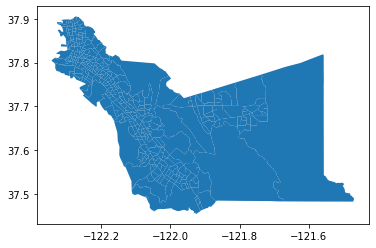

In [7]:
tracts_gdf_ac = tracts_gdf[tracts_gdf['COUNTYFP']=='001']
tracts_gdf_ac.plot()
plt.show()

## Attribute Joins  between Geodataframes and  Dataframes

We just mapped the census tracts. But what makes a map powerful is when you map the data associated with the locations.

In order to map the ACS data we need to associate it with the tracts. We have polygon data in the `tracts_gdf_ac` geodataframe but no attributes of interest.

In a separate file we have our ACS 5-year data for 2018 `census_variables_CA.csv` that we just imported and read in as a `pandas` dataframe. We're now going to join the columns from that data to the `tracts_gdf_ac` with a common key. This process is called an `attribute join`, which we covered in an earlier notebook.

We're going to be conducting an inner join here -- think about why we do one type of join over another. You can read more about merging in `geopandas` [here](http://geopandas.org/mergingdata.html#attribute-joins).

<img src="https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2017/03/join-types-merge-names.jpg">




In [8]:
tracts_gdf_ac['GEOID'].head()

0    06001400300
1    06001400900
2    06001402200
3    06001402800
4    06001404800
Name: GEOID, dtype: object

In [9]:
acs5data_df['FIPS_11_digit'].head()

0    06001401200
1    06001401300
2    06001401400
3    06001401500
4    06001401600
Name: FIPS_11_digit, dtype: object

Let's do a `left` join to keep all of the census tracts in Alameda County and only the ACS data for those tracts.

In [10]:
# Left join keeps all tracts and the acs data for those tracts
tracts_acs_gdf_ac = tracts_gdf_ac.merge(acs5data_df_ac, left_on='GEOID',right_on="FIPS_11_digit", how='left')
tracts_acs_gdf_ac.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME_x,LSAD,ALAND,AWATER,geometry,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,"POLYGON ((-122.26416 37.84000, -122.26186 37.8...",...,0.840542,0.045069,0.058407,0.031528,0.024454,0.420840,0.059496,0.280672,0.067899,0.057479
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.28558 37.83978, -122.28319 37.8...",...,0.906161,0.065687,0.005712,0.022440,0.000000,0.555718,0.068915,0.213343,0.060850,0.044721


Let's see all the variables we have in our dataset now.

In [11]:
list(tracts_acs_gdf_ac.columns)

['STATEFP',
 'COUNTYFP',
 'TRACTCE',
 'AFFGEOID',
 'GEOID',
 'NAME_x',
 'LSAD',
 'ALAND',
 'AWATER',
 'geometry',
 'NAME_y',
 'c_race',
 'c_white',
 'c_black',
 'c_asian',
 'c_latinx',
 'state_fips',
 'county_fips',
 'tract_fips',
 'med_rent',
 'med_hhinc',
 'c_tenants',
 'c_owners',
 'c_renters',
 'c_movers',
 'c_stay',
 'c_movelocal',
 'c_movecounty',
 'c_movestate',
 'c_moveabroad',
 'c_commute',
 'c_car',
 'c_carpool',
 'c_transit',
 'c_bike',
 'c_walk',
 'year',
 'FIPS_11_digit',
 'p_white',
 'p_black',
 'p_asian',
 'p_latinx',
 'p_owners',
 'p_renters',
 'p_stay',
 'p_movelocal',
 'p_movecounty',
 'p_movestate',
 'p_moveabroad',
 'p_car',
 'p_carpool',
 'p_transit',
 'p_bike',
 'p_walk']

How many rows and columns should we have? Think about this before you run the next lines of code.

In [12]:
print("Rows and columns in the Alameda County Census tract gdf:", tracts_gdf_ac.shape)
print("Rows and columns in the Alameda County Census tract gdf joined to the ACS data:", tracts_acs_gdf_ac.shape)

Rows and columns in the Alameda County Census tract gdf: (361, 10)
Rows and columns in the Alameda County Census tract gdf joined to the ACS data: (361, 54)


In [13]:
# can make choropleths for this now! exercise to make one?

## 7.2 Spatial Join

In [14]:
california_places = gpd.read_file('zip://notebook_data/census/Places/cb_2018_06_place_500k.zip')
california_places.head()

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,46492,02411054,1600000US0646492,0646492,Maywood,25,3052102,0,"POLYGON ((-118.20416 33.98952, -118.20433 33.9..."
1,06,17750,02410282,1600000US0617750,0617750,Cypress,25,17127728,21850,"POLYGON ((-118.06332 33.83153, -118.06123 33.8..."
2,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8..."
3,06,69088,02411819,1600000US0669088,0669088,Santa Clarita,25,170638259,162849,"MULTIPOLYGON (((-118.56481 34.35969, -118.5591..."
4,06,13392,02409461,1600000US0613392,0613392,Chula Vista,25,128547314,6380537,"POLYGON ((-117.12399 32.64636, -117.11707 32.6..."


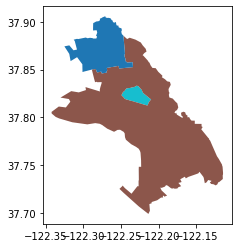

In [15]:
places_list = ['Berkeley','Oakland','Piedmont']
berk_oak_pied = california_places.loc[california_places['NAME'].isin(places_list)].copy().reset_index(drop=True)
berk_oak_pied.plot(column='NAME', categorical=True)

In [16]:
berk_oak_pied.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
schools_df = pd.read_csv('notebook_data/alco_schools.csv')
schools_gdf = gpd.GeoDataFrame(schools_df, 
                               geometry=gpd.points_from_xy(schools_df.X, schools_df.Y))
schools_gdf.crs = "epsg:4326"

In [18]:
schools_gdf = schools_gdf.to_crs('epsg:4269')

In [19]:
schools_gdf['number_of_schools'] = 1

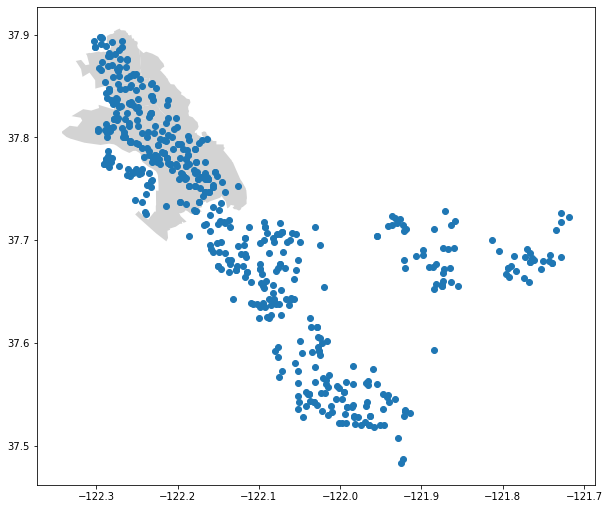

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
berk_oak_pied.plot(color='lightgrey',ax=ax)
schools_gdf.plot(ax=ax)

In [21]:
# Take a look at the function documentation
help(gpd.sjoin)

Help on function sjoin in module geopandas.tools.sjoin:

sjoin(left_df, right_df, how='inner', op='intersects', lsuffix='left', rsuffix='right')
    Spatial join of two GeoDataFrames.
    
    Parameters
    ----------
    left_df, right_df : GeoDataFrames
    how : string, default 'inner'
        The type of join:
    
        * 'left': use keys from left_df; retain only left_df geometry column
        * 'right': use keys from right_df; retain only right_df geometry column
        * 'inner': use intersection of keys from both dfs; retain only
          left_df geometry column
    op : string, default 'intersects'
        Binary predicate, one of {'intersects', 'contains', 'within'}.
        See http://shapely.readthedocs.io/en/latest/manual.html#binary-predicates.
    lsuffix : string, default 'left'
        Suffix to apply to overlapping column names (left GeoDataFrame).
    rsuffix : string, default 'right'
        Suffix to apply to overlapping column names (right GeoDataFrame).



Now, let's spatially join the permit data to the census data so that we can sum the number of permitted units in each census tract.  

In [22]:
# Spatially join permit data to census tract data
places_schools_gdf = gpd.sjoin(berk_oak_pied, schools_gdf)

Now let's take a look at the output of the spatial join.

In [23]:
places_schools_gdf.head(2)

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,X,Y,Site,Address,City,State,Type,API,Org,number_of_schools
0,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8...",...,-122.211319,37.818373,Zion Lutheran,5201 Park Boulevard,Piedmont,CA,K-8,0,private,1
0,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8...",...,-122.234950,37.819717,Wildwood Elementary,301 Wildwood Avenue,Piedmont,CA,ES,964,Public,1


By default `sjoin` is an inner join. It keeps the data from both geodataframes only where the locations spatially intersect. For our join, this means we maintain only those Alameda County census tracts that contain Oakland permit points.

By default `sjoin` maintains the geometry of first geodataframe input to the operation, here census tracts. 

The output of the our `sjoin` operation is the geodataframe `tracts_and_permits_gdf` which has 
- a row for each permit application that is located within a census tract (all of which are)
- the **polygon geometry** of the census tract in which the permit is located
- all of the atribute data columns (non-geometry columns) from both input geodataframes.


To confirm this, let's map the ouput geodataframe.

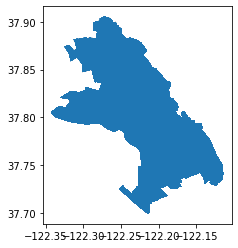

In [24]:
places_schools_gdf.plot()

We are missing some census tracts because not all census tracts contain permit activity **AND** we did an `inner join`
- Where was the inner join specified?

Take a look at the input and ouput the geometry types:

In [25]:
print("Schools input geometry:", schools_gdf.geometry.type.unique())
print("Places input geometry:" , berk_oak_pied.geometry.type.unique())
print("Places and schools join output geometry:", places_schools_gdf.geometry.type.unique())

Schools input geometry: ['Point']
Places input geometry: ['Polygon']
Places and schools join output geometry: ['Polygon']


We joined point data to polygon/multipolygon data and our join output has polygon geometry. Why, because of the order of the inputs to `sjoin` - the polygon geodataframe (census tracts) was listed first.

Now, check out the shape of the input geodataframes and output geodataframes.

In [26]:
print("Schools:", schools_gdf.shape)
print("Places:" , berk_oak_pied.shape)
print("Places and schools:", places_schools_gdf.shape)

Schools: (550, 11)
Places: (3, 10)
Places and schools: (228, 21)


Let's look just at the number of permitted units for this census tract.

So, our sjoin output is not map ready. We first need to aggregate the number of permitted units by census tract, grouping the data by `GEOID` which is a unique identifier.

Ok, let's sum `units_permit` in each census tract.  We can do this using a pandas `groupby` operation.

In [27]:
places_schools_gdf.head()

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,X,Y,Site,Address,City,State,Type,API,Org,number_of_schools
0,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8...",...,-122.211319,37.818373,Zion Lutheran,5201 Park Boulevard,Piedmont,CA,K-8,0,private,1
0,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8...",...,-122.234950,37.819717,Wildwood Elementary,301 Wildwood Avenue,Piedmont,CA,ES,964,Public,1
0,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8...",...,-122.233495,37.823117,Piedmont Middle,740 Magnolia Ave,Piedmont,CA,MS,930,Public,1
0,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8...",...,-122.233084,37.823418,Millennium High Alternative,760 Magnolia Ave,Piedmont,CA,ASAM,0,Public,1
0,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8...",...,-122.232863,37.823655,Piedmont High,800 Magnolia Ave,Piedmont,CA,HS,904,Public,1


In [28]:
places_schools_counts_df = places_schools_gdf[['GEOID','number_of_schools']].groupby('GEOID', as_index=False).sum()
print("Rows and columns:", places_schools_counts_df.shape)

# take a look at the data
places_schools_counts_df.head(7)

Rows and columns: (3, 2)


,GEOID,number_of_schools
0,0606000,32
1,0653000,189
2,0656938,7


The above `groupby` and sum operations give us the counts that we are looking for:
- We have identified the 105 census tracts that contain permit application locations.
- We have the number of `units_permit` within those census tracts. 

But the output of `groupby` is a dataframe not a geodataframe.

If we want to output a spatial geodataframe we can to do one of two things:
1. join the `groupby` output to the tracts_acs_gdf by the attribute `GEOID`
or
2. use the geodataframe [**dissolve**](https://geopandas.org/aggregation_with_dissolve.html) method, which you can think of as a spatial `groupby`. 

Since we already know how to do an attribute join, let's do the `dissolve`.

In [29]:
places_schools_counts_gdf= places_schools_gdf[['GEOID','geometry','number_of_schools']].dissolve(by='GEOID', aggfunc="sum", as_index=False)
print("Rows and columns: ", places_schools_counts_gdf.shape)

# take a look
places_schools_counts_gdf.head(7)

Rows and columns:  (3, 3)


,GEOID,geometry,number_of_schools
0,0606000,"POLYGON ((-122.32519 37.87428, -122.31866 37.8...",32
1,0653000,"POLYGON ((-122.34225 37.80556, -122.33412 37.8...",189
2,0656938,"POLYGON ((-122.24930 37.82372, -122.24812 37.8...",7


Let's break that down.

- The `dissolve` operation requires a geometry column and a grouping column, which above is GEOID. Any geometries within the **same group** will be dissolved if they have the same geometry or nested geometries. 
 
- The `aggfunc`, or aggregation function, of the dissolve operation will be applied to all numeric columns in the input geodataframe (unless the function is `count` in which case it will count rows.)  

Check out the Geopandas documentation on [dissolve](https://geopandas.org/aggregation_with_dissolve.html?highlight=dissolve) for more information.

Above we selected three columns from the input geodataframe to create a subset as input to the dissolve operation. Can you think of why we did that?

### Mapping our Spatial Join Output

Because our `sjoin` plus `dissolve` operation outputs a geodataframe, we can map the count of `units_permit` by census tract.

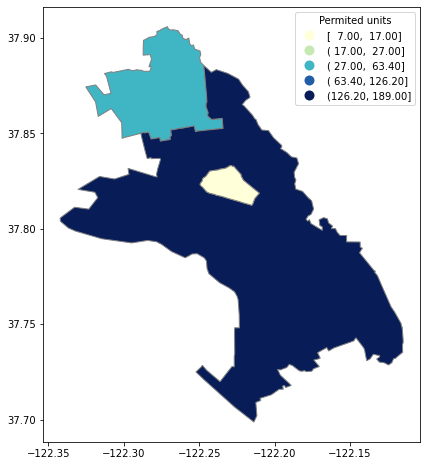

In [30]:
fig, ax = plt.subplots(figsize = (14,8)) 

# Display the output of our spatial join
places_schools_counts_gdf.plot(ax=ax,column='number_of_schools', 
                             scheme="quantiles", 
                             cmap="YlGnBu",
                             edgecolor="grey",
                             legend=True, 
                             legend_kwds={'title':'Permited units'})

plt.show()

## 7.3 Exercise
How many grocery stores in our dataset are in Berkeley, Oakland & Piedmont? 

In [43]:
# SOLUTION
grocery_pts_df = pd.read_csv('notebook_data/other/ca_grocery_stores_2019_wgs84.csv')
grocery_pts_df['number_of_stores'] = 1


grocery_pts_gdf = gpd.GeoDataFrame(grocery_pts_df, 
                               geometry=gpd.points_from_xy(grocery_pts_df.X, grocery_pts_df.Y))
grocery_pts_gdf.crs = "epsg:4326"
grocery_pts_gdf.to_crs('epsg:4269',inplace=True)
grocery_pts_gdf.head()

,X,Y,OBJECTID,LOCNUM,CONAME,STREET,CITY,STATE,STATE_NAME,ZIP,...,FRNCOD,ISCODE,SQFTCODE,LOC_NAME,STATUS,SCORE,SOURCE,REC_TYPE,number_of_stores,geometry
0,-121.9200,36.5479,3302270,414460173,BIO-CHEK LLC,JUNIPERO AVE,CARMEL,CA,California,93923,...,NaN,NaN,4.0,StreetName,M,100.0,INFOGROUP,0,1,POINT (-121.92000 36.54790)
1,-121.9227,36.5530,11234928,729045978,OLIVIER NAPA VALLEY,NW SAN CARLOS ON OCEAN,CARMEL,CA,California,93921,...,NaN,NaN,3.0,Postal,M,100.0,INFOGROUP,0,1,POINT (-121.92270 36.55300)
2,-121.8099,36.5236,12186144,830486544,SAFEWAY,MID VALLEY CTR,CARMEL,CA,California,93923,...,V,NaN,7.0,StreetAddress,M,100.0,INFOGROUP,0,1,POINT (-121.80990 36.52360)
3,-121.9105,36.5367,76567,101734812,SAFEWAY,THE CROSSROADS BLVD,CARMEL,CA,California,93923,...,V,NaN,7.0,StreetAddress,M,100.0,INFOGROUP,0,1,POINT (-121.91050 36.53670)
4,-121.9050,36.5426,1352100,259197937,SAVE MART,CARMEL RANCHO BLVD,CARMEL,CA,California,93923,...,2,NaN,8.0,StreetAddress,M,100.0,INFOGROUP,0,1,POINT (-121.90500 36.54260)


In [45]:
# SOLUTION
places_grocery_gdf = gpd.sjoin(berk_oak_pied, grocery_pts_gdf)

places_grocery_counts_gdf= places_grocery_gdf[['GEOID','geometry','number_of_stores']].dissolve(by='GEOID', aggfunc="sum", as_index=False)



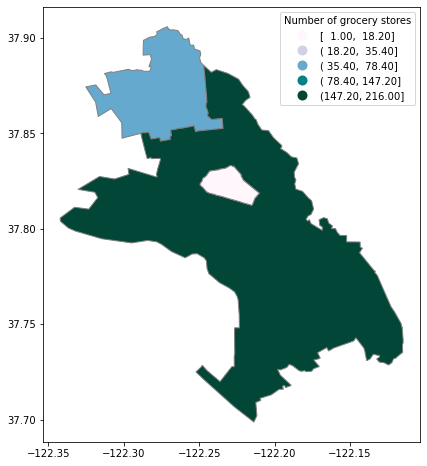

In [46]:
# SOLUTION

fig, ax = plt.subplots(figsize = (14,8)) 

# Display the output of our spatial join
places_grocery_counts_gdf.plot(ax=ax,column='number_of_stores', 
                             scheme="quantiles", 
                             cmap="PuBuGn",
                             edgecolor="grey",
                             legend=True, 
                             legend_kwds={'title':'Number of grocery stores'})

plt.show()



---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="../assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
        


